### Drive mount

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:

%cd /content/drive/MyDrive/AP/TP2

!ls

/content/drive/.shortcut-targets-by-id/1PHYG04I0Rq1HPcXLG6rnTDHoHEepF_XK/AP/TP2
 BaseDL2.ipynb	        models		  smol_snek.ipynb     weights
 demos		        model_viz3D.png   snake_game.py
 DL2Test.ipynb	        __pycache__	  snek.ipynb
'Kopia DL2Test.ipynb'   rewardsANDsteps   TestingSnek.ipynb


### Game

In [3]:
import numpy as np
from numpy.random import randint

class SnakeGame:
    " Implements the snake game core"

    def __init__(self, width, height, food_amount=1,
                 border = 0, grass_growth = 0,
                 max_grass = 0):
        "Initialize board"
        self.width = width
        self.height = height
        self.board = np.zeros( (height,width,3),dtype = np.float32)
        self.food_amount = food_amount
        self.border = border
        self.grass_growth = grass_growth
        self.grass = np.zeros( (height,width) ) + max_grass
        self.max_grass = max_grass
        self.reset()

    def create_apples(self):
        "create a new apple away from the snake"
        while len(self.apples)<self.food_amount:
            apple = ( randint(0,self.height-1), randint(0,self.width-1) )
            while apple in self.snake:
                apple = ( randint(0,self.height-1), randint(0,self.width-1) )
            self.apples.append(apple)

    def create_snake(self):
        "create a snake, size 3, at random position and orientation"
        x = randint( 5, self.width-5 )   # not t0o close to border
        y = randint( 5, self.height-5 )
        self.direction = randint(0,4)
        self.snake = []
        for i in range(5):
            if self.direction == 0:
                y = y+1
            elif self.direction==1:
                x = x-1
            elif self.direction==2:
                y = y-1
            elif self.direction==3:
                x = x+1
            self.snake.append( (y,x) )

    def grow_snake(self, d):
        "add one position to snake head (0=up, 1=right, 2=down, 3=left)"
        y,x = self.snake[0]
        if d == 0:
            y = y-1
        elif d == 1:
            x = x+1
        elif d == 2:
            y = y+1
        else:
            x = x-1
        self.snake.insert(0,(y,x))

    def check_collisions(self):
        "check if game is over by colliding with edge or itself"
        # just need to check snake's head
        x,y = self.snake[0]
        if (x == -1 or x == self.height 
            or y == -1 or y == self.width
            or (x,y) in self.snake[1:]):
            self.done = True

    def step(self, action):        
        """
        move snake/game one step 
        action can be -1 (turn left), 0 (continue), 1 (turn rignt)
        """
        direction = int(action)
        assert -1<=direction<=1        
        self.direction+=direction
        if self.direction<0:
            self.direction = 3
        elif self.direction>3:
            self.direction = 0
        self.grow_snake(self.direction)  # two steps: grow+remove last
        if self.snake[0] in self.apples:            
            self.apples.remove(self.snake[0])
            reward = 1
            self.create_apples()     # new apple
        else:
            self.snake.pop()
            self.check_collisions()
            if self.done:
                reward = -1
            else:
                reward = 0
        if reward>=0:
            x,y = self.snake[0]
            reward += self.grass[x,y]
            self.grass[x,y] = 0
            self.score+=reward
            self.grass += self.grass_growth 
            self.grass[self.grass>self.max_grass] = self.max_grass
                
        return self.board_state(),reward,self.done, {'score':self.score}

    def get_state(self):
        "easily get current state (score, apple, snake head and tail)"        
        score = self.score
        apple = self.apples
        head = self.snake[0]
        tail = self.snake[1:]
        return score,apple,head,tail,self.direction
        
    def print_state(self):
        "print the current board state"
        for i in range(self.height):
            line='.'*self.width
            for x,y in self.apples:
                if y==i:
                    line = line[:x]+'A'+line[x+1:]
            for s in self.snake:
                x,y=s
                if y==i:
                    line = line[:x]+'X'+line[x+1:]
            print(line)

    def test_step(self, direction):
        "to test: move the snake and print the game state"
        self.step(direction)
        self.print_state()
        if self.done:
            print("Game over! Score=",self.score)
    
    def reset(self):
        "reset state"
        self.score = 0
        self.done = False
        self.create_snake()
        self.apples = []
        self.create_apples()
        self.grass[:,:] =  self.max_grass
        
        return self.board_state(),0,self.done, {'score':self.score}
    
    def board_state(self, mode='human', close=False):
        "Render the environment"
        self.board[:,:,:] = 0
        if self.max_grass>0:
            self.board[:,:,1] = self.grass/self.max_grass * 0.3
        if not self.done:
            x,y = self.snake[0]
            self.board[x,y,:] = 1
        for x,y in self.snake[1:]:
            self.board[x,y,0] = 1
        for x,y in self.apples: 
            self.board[x,y,1] = 1
        if self.border == 0:
            return self.board
        else:
            h,w,_ = self.board.shape
            board = np.full((h+self.border*2,w+self.border*2,3),0.5,np.float32)
            board[self.border:-self.border,self.border:-self.border] = self.board 
            return board

#just run this if this file is the main
if __name__ == '__main__':
    game = SnakeGame(20,20)
    game.print_state()
    

....................
....................
....................
....................
....................
....................
....................
.........X..........
.........X..........
.........X..........
.........X..........
.........X..........
....................
....................
...........A........
....................
....................
....................
....................
....................


### Demo

<class 'numpy.ndarray'>


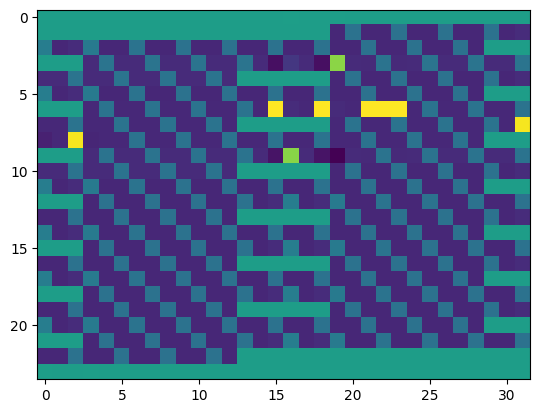

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def plot_board(file_name, board, text=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(board)
    plt.axis("off")
    if text is not None:
        plt.gca().text(3, 3, text, fontsize=45, color="yellow")
    plt.savefig(file_name, bbox_inches="tight")
    plt.close()


def snake_demo(actions):
    game = SnakeGame(
        14, 14, food_amount=2, border=1, grass_growth=0.001, max_grass=0.05
    )
    board, reward, done, info = game.reset()
    action_name = {-1: "Turn left", 0: "Straight ahead", 1: "Turn right"}
    plot_board("0.png", board, "Start")
    for frame, action in enumerate(actions):
        board, reward, done, info = game.step(action)
        plot_board(f"{frame+1}.png", board, action_name[action])
    return board


board = snake_demo([0, 1, -1, 1, 1, 0])
plt.imshow(board)
flattened_frames = np.reshape(board, (board.shape[0], -1))
pca = PCA(n_components=4)  
latent_representation = pca.fit_transform(flattened_frames)
reconstructed_frames = pca.inverse_transform(latent_representation)
        #RESHAPE
reconstructed_frames = np.reshape(reconstructed_frames, ( 24,32))
plt.imshow(reconstructed_frames)
print(type(board))

### Heuristic agent

In [ ]:
from math import sqrt
from copy import deepcopy

class HeuristicAgent:
    def __init__(self, env: SnakeGame):
        self.env = env
        self.possible_actions = [-1, 0, 1]
        self.possible_directions = list(range(4))

    def generate_examples(self, n: int, force_trunc: bool = False):
        """
        Plays new games according to a heuristic policy until number of example transitions exceeds n.
        Setting `force_trunc` to True forces output list to have size = n.
        """
        examples = list()
        while len(examples) < n:
            transitions = self._play_game()
            examples.extend(transitions)
            print(f"Currently there is {len(examples)} examples")
        return examples if not force_trunc else examples[:n]

    def _play_game(self):
        transitions = list()
        board_state, _, done, _ = self.env.reset()
        steps = 0
        total_reward = 0
        while not done:
            new_state, reward, done, _, action = self._take_action(
                *self.env.get_state()
            )
            transition = (board_state, action, reward, new_state, done)
            transitions.append(transition)
            board_state = new_state
            steps += 1
            total_reward += reward
            if steps % 100 == 0:
                print(f"After {steps} steps total reward = {total_reward}")
        return transitions

    def _take_action(self, score, apples, head, tail, direction):
        closest_apple = min(apples, key=lambda apple: distance(apple, head))
        action_scores = list()
        for action in self.possible_actions:
            _env = deepcopy(self.env)
            _, reward, done, _ = _env.step(action)
            if reward == 1:
                action_scores.append(0)
            elif done:
                action_scores.append(self.env.width * self.env.height * 2)
            else:
                _, _, head, _, _ = _env.get_state()
                action_scores.append(distance(head, closest_apple))
        action = np.argmin(action_scores) - 1
        return *self.env.step(action), action


def distance(p1: tuple, p2: tuple):
    x1, y1 = p1
    x2, y2 = p2
    return sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

### DQN Agent

#### Own DQN Agent

In [31]:
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2



class DQN_Agent:
    def __init__(
        self,
        state_shape,
        action_space,
        epsilon=0.0,
        epsilon_decay=0.995,
        min_epsilon=0.0,
        discount_factor=0.97,
        learning_rate=0.0005,
        batch_size=2**12,
        replay_buffer_size=2**14,
        initial_buffer=list(),
    ):
        # Arguments assignmen
        # game.board_state().shape
        self.state_shape = state_shape
        self.action_space = action_space
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.reward_list = []
        self.step_list=[]

        # Methods assignment(func)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        self.update_target_model()
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.replay_buffer.extend(initial_buffer)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def update_replay_buffer(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.replay_buffer.append(transition)

    def fit_replay(self):
        # If replay buffer is not filled yet return nothing
        if len(self.replay_buffer) < self.batch_size:
            return

        batch_random = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []

        #TODO: rewrite into list comprehension
        for transition in batch_random:
            state, action, reward, next_state, done = transition
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)

        future_q_values = self.target_model.predict(next_states) 
        future_q_values_ids=np.argmax(future_q_values,axis=1)
        #print(future_q_values_ids)

        max_q_values = np.max(future_q_values, axis=1) 
        max_q_values[dones] = 0
        max_future_q_values = rewards + self.discount_factor * max_q_values

        q_values = self.model.predict(states)

        #print(q_values)
       # print(q_values.shape)

        # Update action specific qvalue and keep the rest unchanged
        for i,action in enumerate(actions):  
            _action=action+1         
            q_values[i][_action] = max_future_q_values[i] 
            #print(future_q_values[i])
            #print(np.argmax(future_q_values[i]))
        
        #PCA for feature extraction
        flattened_frames = np.reshape(states, (states.shape[0], -1))
        pca = PCA(n_components=8)  
        latent_representation = pca.fit_transform(flattened_frames)
        reconstructed_frames = pca.inverse_transform(latent_representation)
        #RESHAPE
        reconstructed_frames = np.reshape(reconstructed_frames, (reconstructed_frames.shape[0], 16, 16, 3))

        self.model.fit(states, q_values, batch_size=2048,epochs=20, verbose=0)

          
      
    def create_model(self):
        model = Sequential()
        model.add(layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x), input_shape=self.state_shape))
        model.add(
            layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                #strides=(2,2),
                activation="relu",
                padding="same",
                kernel_initializer=tf.keras.initializers.HeNormal(),
                #input_shape=self.state_shape,
            )
        )

        model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(layers.BatchNormalization())

        model.add(
            layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                activation="relu",
                padding="same",
                kernel_initializer=tf.keras.initializers.HeNormal(),
                #kernel_regularizer=tf.keras.regularizers.L2(0.01),
            )
        )
        model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.15))

        model.add(
            layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                activation="relu",
                padding="same",
                kernel_initializer=tf.keras.initializers.HeNormal(),
                #kernel_regularizer=tf.keras.regularizers.L2(0.01),
            )
        )
        model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.15))

        model.add(layers.Flatten())
        model.add(
            layers.Dense(
                64, activation="relu", 
                #kernel_regularizer=tf.keras.regularizers.L2(0.01),
            )
        )
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.15))
        model.add(
            layers.Dense(
                32, activation="relu",
                 #kernel_regularizer=tf.keras.regularizers.L2(0.01),
            )
        )
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.15))

        # action_space.size = 3learning_rate
        model.add(layers.Dense(3, activation="linear", kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)))
        model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=self.learning_rate),metrics=['accuracy'])
        model.load_weights("./models/NEWmodel1500e")
        return model

    def step_choice(self, state32):
        # Reshape with 1 int at the beggining for tf buffer
        state = state32.reshape((1, self.state_shape[0], self.state_shape[1], 3))
        if np.random.rand() < self.epsilon:
            return random.choice([-1,0,1])
        else:
            # Pick which Q value form model output is highest
            q_values = self.model.predict(state)
            return np.argmax(q_values)-1

    def video_choice(self, state):
        q_values = self.model.predict(state)
        return np.argmax(q_values)-1

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

    def train(self, env, episodes):
        step_counter = 0
        TR = -0.8
        
        for episode in range(episodes):
            step_counter_display=0
            state, _, _, _ = env.reset()
         
            done = False
            total_reward = 0
            self.decay_epsilon()
            while not done:
                step_counter += 1
                step_counter_display += 1

                action = self.step_choice(state) 
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                state = next_state
              
                
                self.update_replay_buffer(state, action, reward, next_state, done)

            if (episode+1) % 6 == 0 :
                self.fit_replay()

            if (episode+1) % 21  == 0:
                self.update_target_model()
                #step_counter = 0

            self.step_list.append(step_counter_display)
            self.reward_list.append(total_reward)
            print(f"Episode {episode}, steps :{step_counter_display}, reward: {total_reward}")
            

    def plot_rewards(self):
      episodes = range(1, len(self.reward_list) + 1)
    
      fig, axs = plt.subplots(nrows=1, ncols=2)
      fig.set_size_inches(12, 5)
    
      # Plot total reward
      axs[0].plot(episodes, self.reward_list)
      axs[0].set_xlabel("Episode")
      axs[0].set_ylabel("Total Reward")
      axs[0].set_title("Total Reward per Episode")
    
      # Plot step list
      axs[1].plot(episodes, self.step_list,color='orange')
      axs[1].set_xlabel("Episode")
      axs[1].set_ylabel("Step Count")
      axs[1].set_title("Step Count per Episode")
    
      plt.tight_layout()
      plt.show()


 



#### Keras DQN Agent

In [ ]:
!pip install tf_agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Training

#### Create game

In [5]:
game = SnakeGame(
    width=14, height=14, border=1, food_amount=1, grass_growth=0.001, max_grass=0.05
)
#0.001 grass growth
state_shape = game.board_state().shape
action_space = 3  # Left,Same, Right
print(state_shape)

(16, 16, 3)


#### Generate examples

In [ ]:
hewra = HeuristicAgent(game)
initial_examples = hewra.generate_examples(2**17)

#### Train agent

In [6]:
#print(len(initial_examples))
import os
save_dir = './rewardsANDsteps/'
replay_memory_array = np.load(os.path.join(save_dir, 'NEWreplay_memory2500.npy'), allow_pickle=True)
replay_memory1 = deque(replay_memory_array)



In [7]:
del replay_memory_array

In [ ]:
agent = DQN_Agent(state_shape, action_space, initial_buffer=replay_memory1, batch_size=2**13, replay_buffer_size=2**17, min_epsilon=0.03, learning_rate=0.0001)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
Episode 192, steps :30, reward: 3.1279999999999992
1/1 [==============================] - 0s 30ms/step
Episode 193, steps :5, reward: -0.8
1/1 [==============================] - 0s 33ms/step
Episode 194, steps :3, reward: -0.9
1/1 [==============================] - 0s 27ms/step
Episode 195, steps :16, reward: 1.75
1/1 [==============================] - 0s 29ms/step
Episode 196, steps :6, reward: -0.75
256/256 [==============================] - 1s 4ms/step
Episode 197, steps :6, reward: 0.2500000000000002
1/1 [==============================] - 0s 27ms/step
Episode 198, steps :13, reward: 1.6000000000000005
1/1 [==============================] - 0s 25ms/step
Episode 199, steps :17, reward: 0.7560000000000002
1/1 [==============================] - 0s 26ms/step
Episode 200, steps :11, reward: 0.5
1/1 [==============================] - 0s 26ms/step
Episode 201, steps :39, reward: 2.6759999

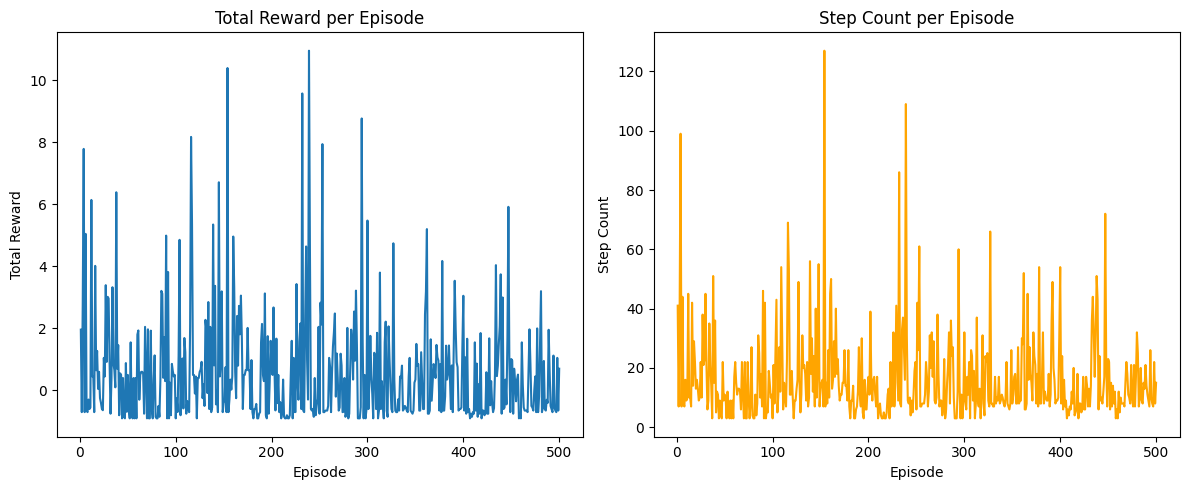

0.03


<ipython-input-8-0a22b745000c>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  replay_memory_array = np.array(agent.replay_buffer)


In [8]:
#State shape for grayscale
#state_shape=(16,16,1)
agent = DQN_Agent(state_shape, action_space, initial_buffer=replay_memory1, batch_size=2**13, replay_buffer_size=2**17, min_epsilon=0.03, learning_rate=0.0001)
agent.train(game,500)
agent.plot_rewards()
print(agent.epsilon)


#SAVING data
agent.model.save_weights('./models/BESTmodel3000e')
rewards = agent.reward_list  # Example rewards array
steps=agent.step_list
save_dir = './rewardsANDsteps/'  # Specify the subdirectory name
file_name = 'BESTrewards3000.npy'  # Specify the desired file name
file_name2 ='BESTsteps3000.npy'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

replay_memory_array = np.array(agent.replay_buffer)
np.save(os.path.join(save_dir, 'BESTreplay_memory3000.npy'), replay_memory_array)


np.save(os.path.join(save_dir, file_name), rewards)
np.save(os.path.join(save_dir, file_name2), steps)

# SAVING 

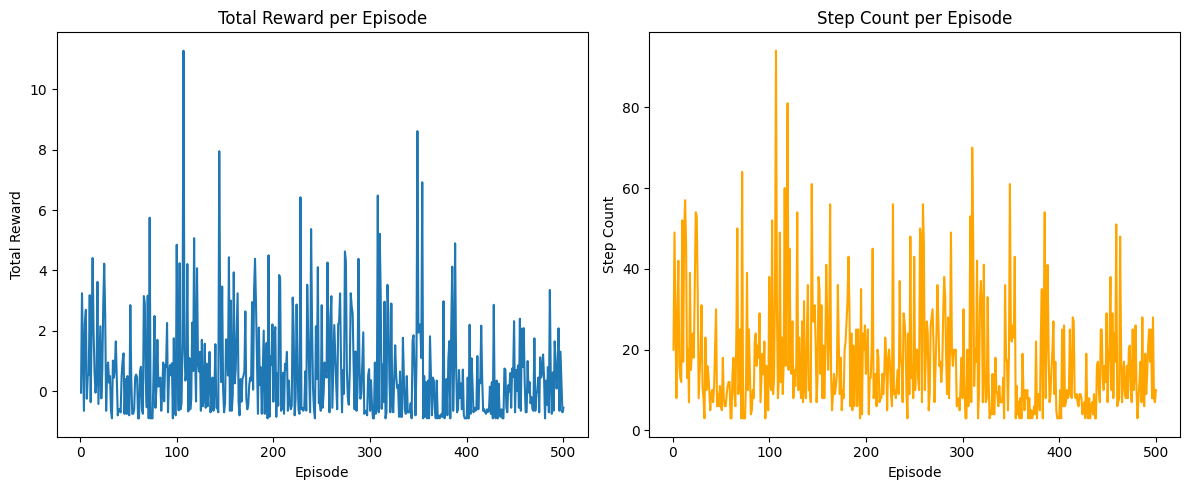

0.03
8768


<ipython-input-97-c117710d06d0>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  replay_memory_array = np.array(agent.replay_buffer)


In [ ]:
agent.plot_rewards()
print(agent.epsilon)
print(np.sum(agent.step_list))

#agent.model.save_weights('./models/NEWmodel1500e')


rewards = agent.reward_list  # Example rewards array
steps=agent.step_list
save_dir = './rewardsANDsteps/'  # Specify the subdirectory name
file_name = 'NEWrewards3000.npy'  # Specify the desired file name
file_name2 ='NEWsteps3000.npy'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

replay_memory_array = np.array(agent.replay_buffer)
np.save(os.path.join(save_dir, 'NEWreplay_memory3000.npy'), replay_memory_array)


np.save(os.path.join(save_dir, file_name), rewards)
np.save(os.path.join(save_dir, file_name2), steps)

In [ ]:
print(initial_examples[0])

In [ ]:
print(random.choice([-1,0,1]))

-1


# MOVIE Maker


In [ ]:
import cv2
import numpy as np
import imageio


def agent_play(agent, game, filename="demos/agent_playBEST3ep.mp4"):
    board, reward, done, info = game.reset()
    action_name = {-1: "Turn left", 0: "Straight ahead", 1: "Turn right"}
    frames = [board]
    episode_reward=0
    while not done:
        action = agent.step_choice(board)  # Get action from the agent
        board, reward, done, info = game.step(action )
        episode_reward += reward
        frames.append(board)
    height, width, _ = frames[0].shape
    print(episode_reward)
    
    if (episode_reward > 10):
      with imageio.get_writer(filename, format="FFMPEG", mode="I", fps=4) as writer:
          for frame in frames:
              resized_frame = cv2.resize(
                  frame, (width * 100, height * 100), interpolation=cv2.INTER_NEAREST)
              writer.append_data(resized_frame)
    return board



for i in range(100):
  agent_play(agent, game)

1/1 [==============================] - 0s 26ms/step
0.55
1/1 [==============================] - 0s 34ms/step
-0.45000000000000007
1/1 [==============================] - 0s 57ms/step
-0.5
1/1 [==============================] - 0s 40ms/step
4.667999999999995
1/1 [==============================] - 0s 30ms/step
1.7499999999999982
1/1 [==============================] - 0s 25ms/step
1.6499999999999986
1/1 [==============================] - 0s 30ms/step
1.35
1/1 [==============================] - 0s 38ms/step
5.297999999999996
1/1 [==============================] - 0s 63ms/step
2.5559999999999987
1/1 [==============================] - 0s 120ms/step
0.8500000000000005
1/1 [==============================] - 0s 43ms/step
3.615999999999998
1/1 [==============================] - 0s 40ms/step
-0.65
1/1 [==============================] - 0s 23ms/step
2.0499999999999985
1/1 [==============================] - 0s 49ms/step
5.793999999999993
1/1 [==============================] - 0s 38ms/step
0.30400000

# GRAPH maker

In [ ]:
import numpy as np
rewards_selective = np.load('./rewardsANDsteps/SELECTIVErewards0-1000.npy')
steps_selective = np.load('./rewardsANDsteps/SELECTIVEsteps0-1000.npy')
rewards_new = np.load('./rewardsANDsteps/NEWrewards1500.npy')
steps_new = np.load('./rewardsANDsteps/NEWsteps1500.npy')
rewards_new2 = np.load('./rewardsANDsteps/NEWrewards2000.npy')
steps_new2 = np.load('./rewardsANDsteps/NEWsteps2000.npy')
rewards_new3 = np.load('./rewardsANDsteps/NEWrewards2500.npy')
steps_new3 = np.load('./rewardsANDsteps/NEWsteps2500.npy')
rewards_new4 = np.load('./rewardsANDsteps/NEWrewards3000.npy')
steps_new4 = np.load('./rewardsANDsteps/NEWsteps3000.npy')

rewards = np.concatenate((rewards_selective, rewards_new, rewards_new2, rewards_new3, rewards_new4))
steps = np.concatenate((steps_selective, steps_new, steps_new2,steps_new3,steps_new4))

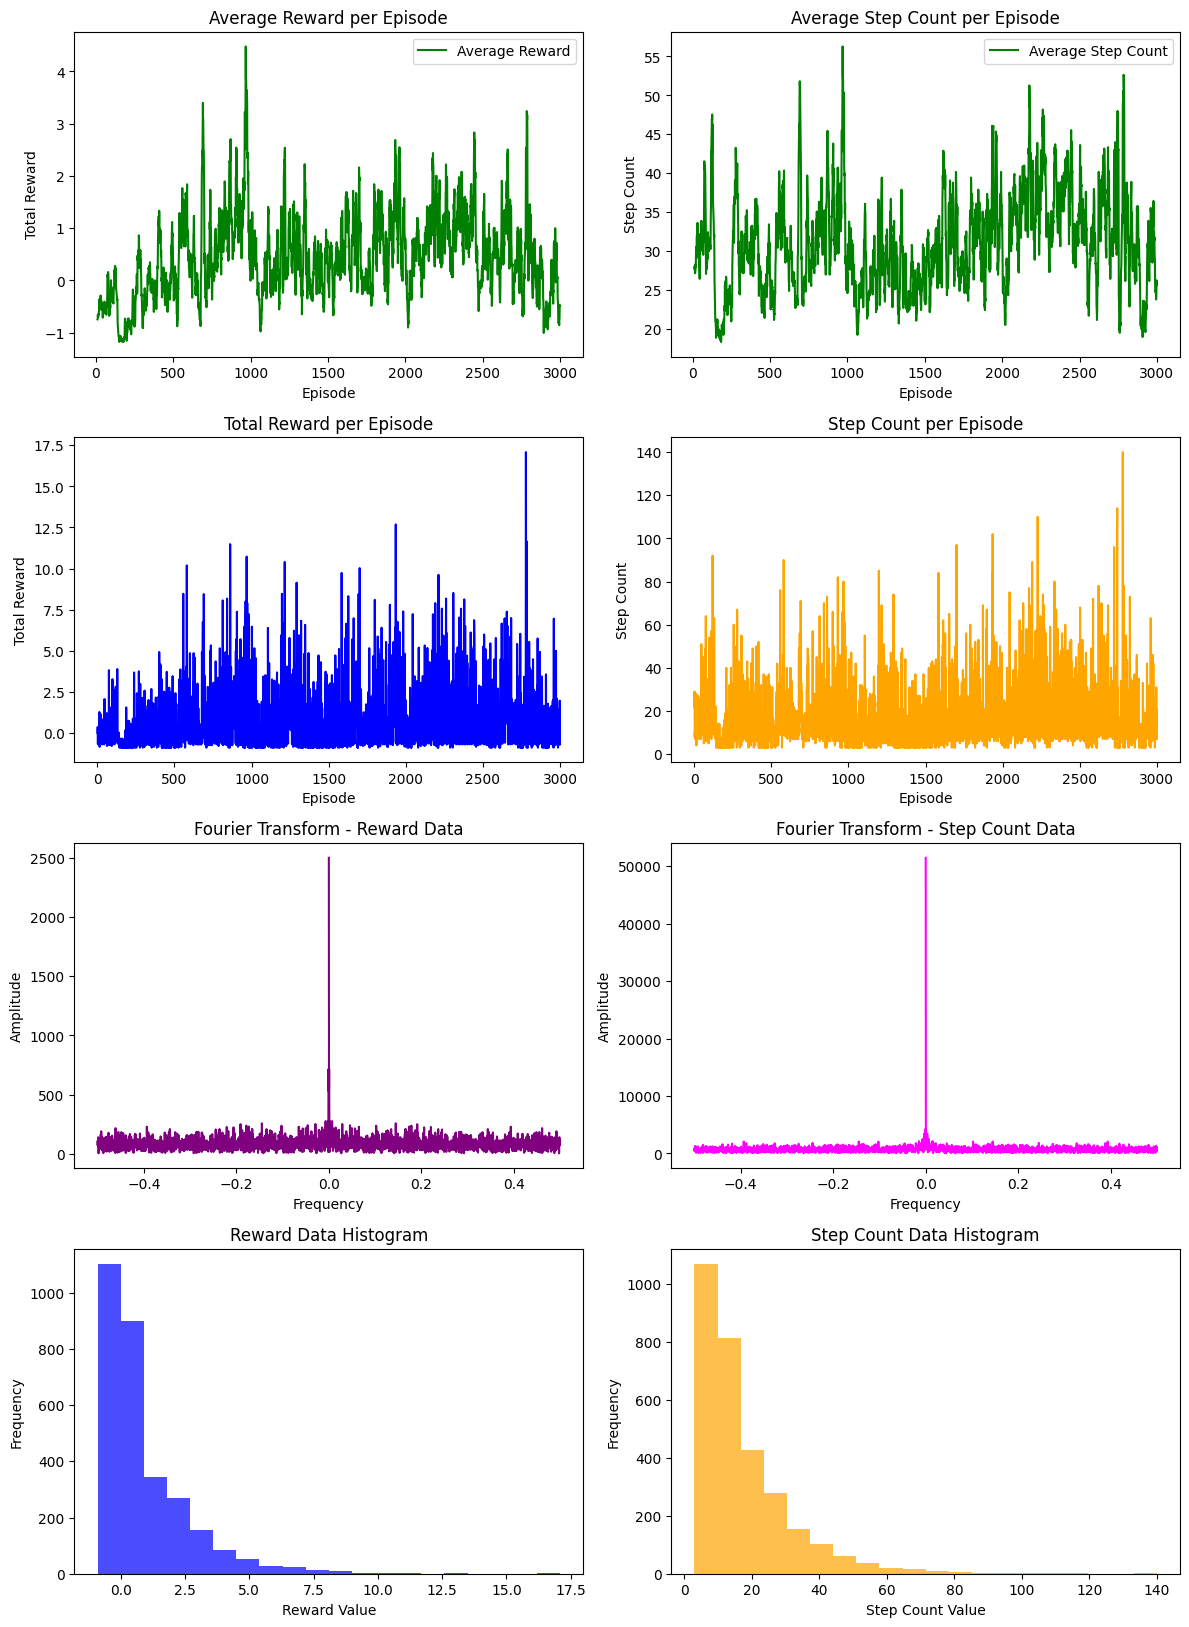

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rewards_avg1(steps,rewards):

    episodes = range(1, len(rewards) + 1)

    fig, axs = plt.subplots(nrows=5, ncols=2)
    fig.set_size_inches(12, 20)

    # Calculate the moving average and offset
    window_size = 11  # Adjust the window size as needed
    reward_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    reward_offset = np.mean(rewards[:window_size-1])

    step_avg = np.convolve(steps, np.ones(window_size) / window_size, mode='valid')
    step_offset = np.mean(steps[:window_size-1])

    # Plot average reward with offset (Top-left subplot)
    axs[0, 0].plot(episodes[window_size-1:], reward_avg + reward_offset, color='green', label='Average Reward')
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].set_title("Average Reward per Episode")
    axs[0, 0].legend()

    # Plot average step count with offset (Top-right subplot)
    axs[0, 1].plot(episodes[window_size-1:], step_avg + step_offset, color='green', label='Average Step Count')
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Step Count")
    axs[0, 1].set_title("Average Step Count per Episode")
    axs[0, 1].legend()

    # Plot total reward (Middle-left subplot)
    axs[1, 0].plot(episodes, rewards, color='blue')
    axs[1, 0].set_xlabel("Episode")
    axs[1, 0].set_ylabel("Total Reward")
    axs[1, 0].set_title("Total Reward per Episode")

    # Plot step count (Middle-right subplot)
    axs[1, 1].plot(episodes, steps, color='orange')
    axs[1, 1].set_xlabel("Episode")
    axs[1, 1].set_ylabel("Step Count")
    axs[1, 1].set_title("Step Count per Episode")

    # Perform Fourier Transform and plot for reward data (Bottom-left subplot)
    reward_fft = np.fft.fft(rewards)
    reward_freq = np.fft.fftfreq(len(rewards))
    axs[2, 0].plot(reward_freq, np.abs(reward_fft), color='purple')
    axs[2, 0].set_xlabel("Frequency")
    axs[2, 0].set_ylabel("Amplitude")
    axs[2, 0].set_title("Fourier Transform - Reward Data")

    # Perform Fourier Transform and plot for step count data (Bottom-right subplot)
    step_fft = np.fft.fft(steps)
    step_freq = np.fft.fftfreq(len(steps))
    axs[2, 1].plot(step_freq, np.abs(step_fft), color='magenta')
    axs[2, 1].set_xlabel("Frequency")
    axs[2, 1].set_ylabel("Amplitude")
    axs[2, 1].set_title("Fourier Transform - Step Count Data")

    # Plot histogram for reward data (Bottom-left subplot)
    axs[3, 0].hist(rewards, bins=20, color='blue', alpha=0.7)
    axs[3, 0].set_xlabel("Reward Value")
    axs[3, 0].set_ylabel("Frequency")
    axs[3, 0].set_title("Reward Data Histogram")

    # Plot histogram for step count data (Bottom-right subplot)
    axs[3, 1].hist(steps, bins=20, color='orange', alpha=0.7)
    axs[3, 1].set_xlabel("Step Count Value")
    axs[3, 1].set_ylabel("Frequency")
    axs[3, 1].set_title("Step Count Data Histogram")

    # Remove unused subplots
    axs[4, 0].remove()
    axs[4, 1].remove()

    plt.tight_layout()
    plt.show()

plot_rewards_avg1(steps,rewards)


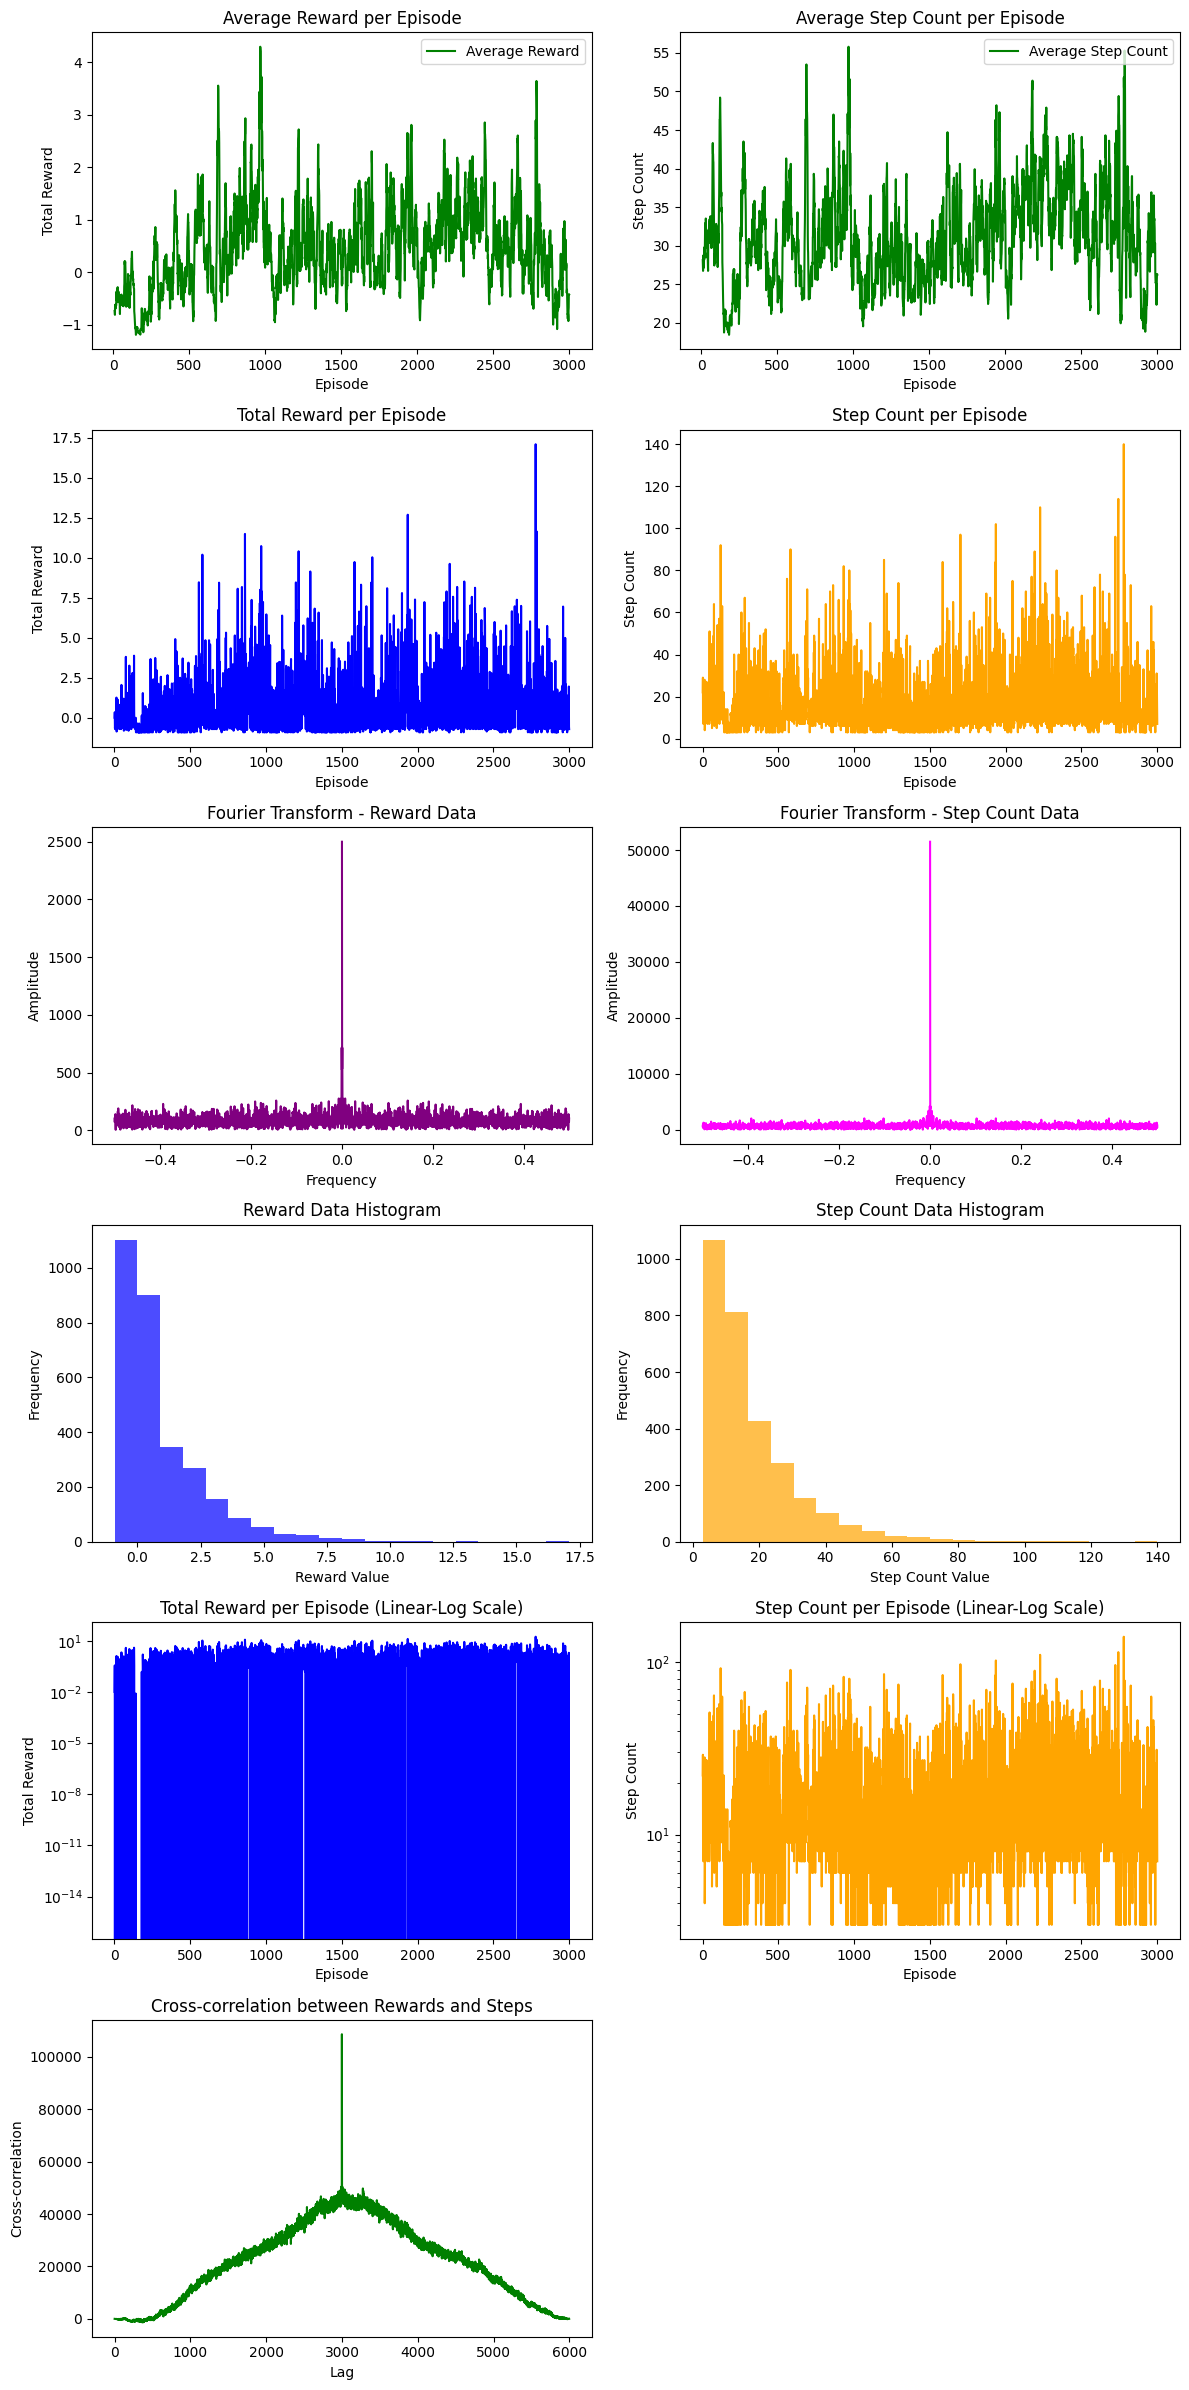

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rewards_avg2(steps,rewards):

    episodes = range(1, len(rewards) + 1)

    fig, axs = plt.subplots(nrows=6, ncols=2)
    fig.set_size_inches(12, 24)

    # Calculate the moving average and offset
    window_size = 21  # Adjust the window size as needed
    reward_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    reward_offset = np.mean(rewards[:window_size-1])

    step_avg = np.convolve(steps, np.ones(window_size) / window_size, mode='valid')
    step_offset = np.mean(steps[:window_size-1])

    # Plot average reward with offset (Top-left subplot)
    axs[0, 0].plot(episodes[window_size-1:], reward_avg + reward_offset, color='green', label='Average Reward')
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].set_title("Average Reward per Episode")
    axs[0, 0].legend()

    # Plot average step count with offset (Top-right subplot)
    axs[0, 1].plot(episodes[window_size-1:], step_avg + step_offset, color='green', label='Average Step Count')
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Step Count")
    axs[0, 1].set_title("Average Step Count per Episode")
    axs[0, 1].legend()

    # Plot total reward (Middle-left subplot)
    axs[1, 0].plot(episodes, rewards, color='blue')
    axs[1, 0].set_xlabel("Episode")
    axs[1, 0].set_ylabel("Total Reward")
    axs[1, 0].set_title("Total Reward per Episode")

    # Plot step count (Middle-right subplot)
    axs[1, 1].plot(episodes, steps, color='orange')
    axs[1, 1].set_xlabel("Episode")
    axs[1, 1].set_ylabel("Step Count")
    axs[1, 1].set_title("Step Count per Episode")

    # Perform Fourier Transform and plot for reward data (Bottom-left subplot)
    reward_fft = np.fft.fft(rewards)
    reward_freq = np.fft.fftfreq(len(rewards))
    axs[2, 0].plot(reward_freq, np.abs(reward_fft), color='purple')
    axs[2, 0].set_xlabel("Frequency")
    axs[2, 0].set_ylabel("Amplitude")
    axs[2, 0].set_title("Fourier Transform - Reward Data")

    # Perform Fourier Transform and plot for step count data (Bottom-right subplot)
    step_fft = np.fft.fft(steps)
    step_freq = np.fft.fftfreq(len(steps))
    axs[2, 1].plot(step_freq, np.abs(step_fft), color='magenta')
    axs[2, 1].set_xlabel("Frequency")
    axs[2, 1].set_ylabel("Amplitude")
    axs[2, 1].set_title("Fourier Transform - Step Count Data")

    # Plot histogram for reward data (Fourth row, left subplot)
    axs[3, 0].hist(rewards, bins=20, color='blue', alpha=0.7)
    axs[3, 0].set_xlabel("Reward Value")
    axs[3, 0].set_ylabel("Frequency")
    axs[3, 0].set_title("Reward Data Histogram")

    # Plot histogram for step count data (Fourth row, right subplot)
    axs[3, 1].hist(steps, bins=20, color='orange', alpha=0.7)
    axs[3, 1].set_xlabel("Step Count Value")
    axs[3, 1].set_ylabel("Frequency")
    axs[3, 1].set_title("Step Count Data Histogram")

    # Plot linear-log scale for reward data (Fifth row, left subplot)
    axs[4, 0].plot(episodes, rewards, color='blue')
    axs[4, 0].set_xlabel("Episode")
    axs[4, 0].set_ylabel("Total Reward")
    axs[4, 0].set_title("Total Reward per Episode (Linear-Log Scale)")
    axs[4, 0].set_yscale('log')

    # Plot linear-log scale for step count data (Fifth row, right subplot)
    axs[4, 1].plot(episodes, steps, color='orange')
    axs[4, 1].set_xlabel("Episode")
    axs[4, 1].set_ylabel("Step Count")
    axs[4, 1].set_title("Step Count per Episode (Linear-Log Scale)")
    axs[4, 1].set_yscale('log')

    # Calculate cross-correlation between rewards and steps
    cross_corr = np.correlate(rewards, steps, mode='full')

    # Plot cross-correlation (Bottom-left subplot)
    axs[5, 0].plot(range(len(cross_corr)), cross_corr, color='green')
    axs[5, 0].set_xlabel("Lag")
    axs[5, 0].set_ylabel("Cross-correlation")
    axs[5, 0].set_title("Cross-correlation between Rewards and Steps")

    # Remove unused subplots
    axs[5, 1].remove()

    plt.tight_layout()
    plt.show()

plot_rewards_avg2(steps,rewards)


# CNN activation 

1/1 [==============================] - 0s 136ms/step


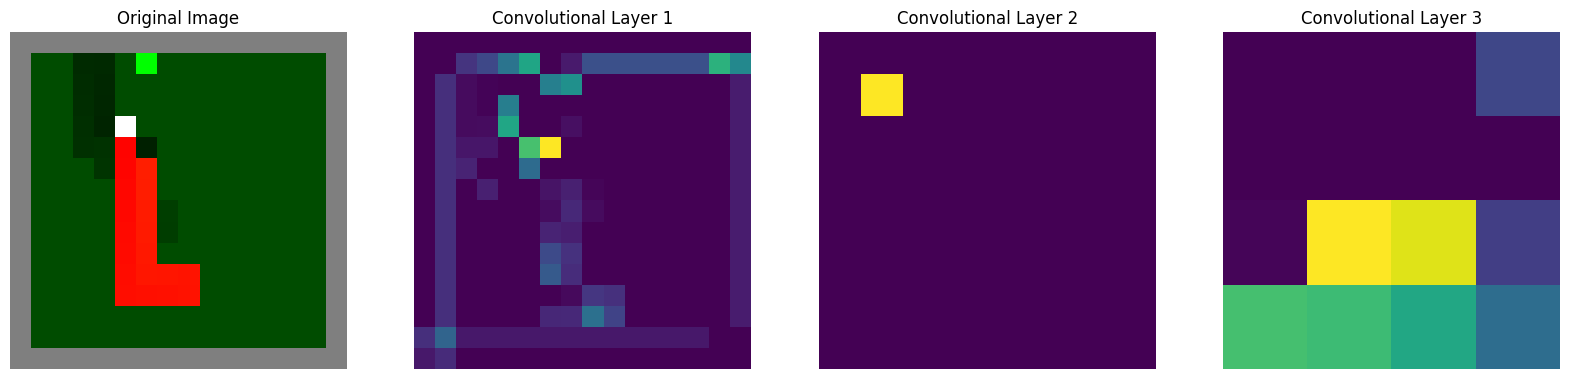

In [ ]:
#visualising activations

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



def visualize_all_activations(model):
    batch_random = random.sample(agent.replay_buffer, 1)
    for transition in batch_random:
      img, action, reward, next_state, done = transition
    # Choose a random image from the provided images
    #img = images[np.random.randint(images.shape[0]), :, :, :]
    
    # Get the activations of all convolutional layers
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)
    activations = activation_model.predict(np.expand_dims(img, axis=0))

    # Plot the original image and activations for each convolutional layer
    fig, axs = plt.subplots(nrows=1, ncols=len(activations)+1)
    fig.set_size_inches(20, 5)


    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    
    for i, activation in enumerate(activations):
        axs[i+1].imshow(activation[0, :, :, 0], cmap='viridis')
        axs[i+1].axis('off')
        axs[i+1].set_title(f'Convolutional Layer {i+1}')
        
    plt.show()


visualize_all_activations(agent.model)

# Test

In [46]:
agent = DQN_Agent(state_shape, action_space, initial_buffer=replay_memory1, batch_size=2**13, replay_buffer_size=2**17, min_epsilon=0.03, learning_rate=0.0001)
agent.model.load_weights("./models/model4k")

In [37]:
def agent_play(agent, game):
    board, reward, done, info = game.reset()
    action_name = {-1: "Turn left", 0: "Straight ahead", 1: "Turn right"}
    episode_reward = 0
    steps = 0
    while not done:
        action = agent.step_choice(board)  # Get action from the agent
        board, reward, done, info = game.step(action )
        episode_reward += reward
        steps += 1
    return episode_reward, steps


In [47]:
rewards = list()
steps = list()
for i in range(100):
    reward, step = agent_play(agent, game)
    rewards.append(reward)
    steps.append(step)
    print(f"##### Game {i} reward {reward} steps {step} #####")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - ETA: 0s

KeyboardInterrupt: ignored

Text(0.5, 1.0, "DQN agent's reward per game after 4000 episodes")

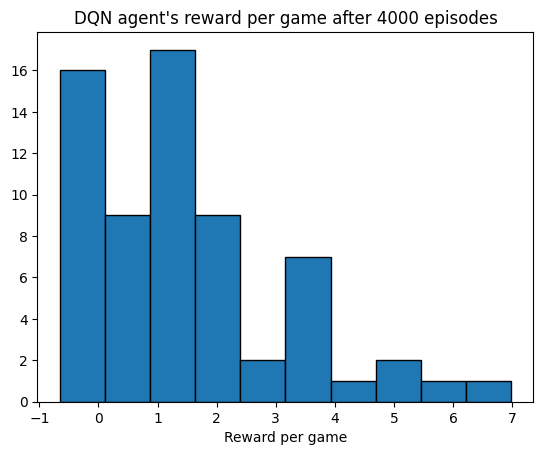

In [48]:
plt.hist(rewards, edgecolor="k",)
plt.xlabel("Reward per game")
plt.title("DQN agent's reward per game after 4000 episodes")

Text(0.5, 1.0, "DQN agent's steps per game after 4000 episodes")

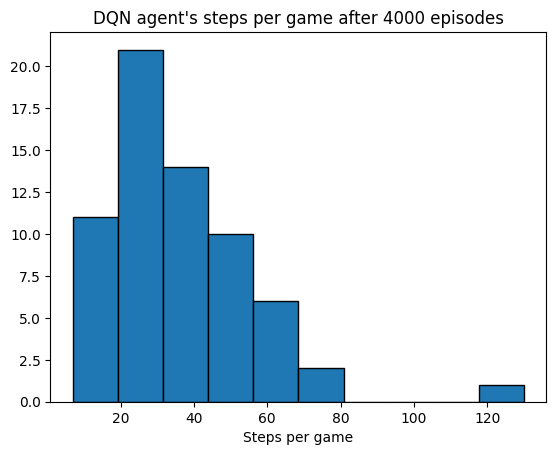

In [49]:
plt.hist(steps, edgecolor="k",)
plt.xlabel("Steps per game")
plt.title("DQN agent's steps per game after 4000 episodes")